### Proyecto 2 - Ciencia de datos

Integrentes: 

- Karina Valladares, 18005 

- Alexa Bravo, 18831

- José Eduardo López, 181045

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neattext as nt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
data =pd.read_csv("train.csv")

data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [6]:
data.isna().sum().to_frame()

,0
id,0
keyword,61
location,2533
text,0
target,0


### Variables

- id: hace referencia a un número único para cada registro, es de tipo numérico (no necesita limpieza). 
    Tenemos 0 datos faltantes. 
- Keyword: es una palabra que caracteriza al tweet, no todos los tweets lo tienen pero no escencial para el análisis de texto, aunque puede resultar de gran ayuda para aquellos tweets que si estén vinculados a una. Es de tipo String y solo necesitamos remover los signos de puntuación y pasar todo a mayúsuculas. Tenemos 61 datos faltantes. 
- Location: hace referencia al país desde el que se publicó el tweet, no todos los registros tienen esta variables pero puede ser de utilidad para los que si la tienen. Para la limpieza solo es necesario estandarizar los nombres y colocar todo en mayúsculas. Tenemos 2,533 datos faltantes.
- text: es el mensaje de texto adjunto al tweet, esta es la variable más importante y la quiere mayor limpieza. Como es una variable que contiene texto es necesaria procesar como lenguaje natural, quitar caracteres especiales, correos, números de teléfono, stopwrods, signos de puntuación, pasar todo a mayúsculas, remover URL, entre otros. Tenemos 0 datos faltantes
- targe: es una variable binaria que clasifica si el tweet es sobre un desastre real: 1, 0 en caso contrario, no requiere limpieza. Tenemos 0 datos faltantes.

## Análisis Exploratorio

In [8]:
final_string = ""
for i in data["keyword"]:
    final_string += str(i) + " "
final_string = final_string[:-1]

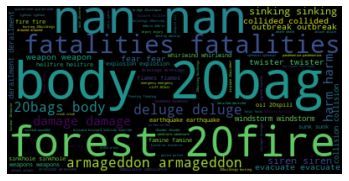

In [9]:
wordcloud = WordCloud().generate(str(final_string))

plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Podemos observar que aparecen valores repetidos y varios "NaN" por ello es necesario hacer limpieza y estandarizar los datos.

In [12]:
final_string = ""
for i in data["location"]:
    final_string += str(i) + " "
final_string = final_string[:-1]

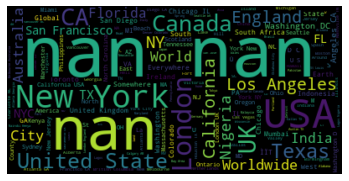

In [13]:
wordcloud = WordCloud().generate(str(final_string))

plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Podemos observar que aparecen valores repetidos y varios "NaN" por ello es necesario hacer limpieza y estandarizar los datos.

In [14]:
final_string = ""
for i in data["text"]:
    final_string += str(i) + " "
final_string = final_string[:-1]

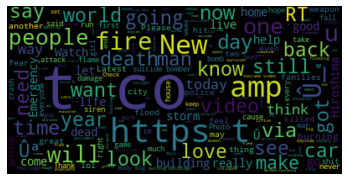

In [15]:
wordcloud = WordCloud().generate(str(final_string))

plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Podemos observar que aparecen valores repetidos y varios "NaN" por ello es necesario hacer limpieza y estandarizar los datos.

In [22]:
pie = data.groupby("target").count()

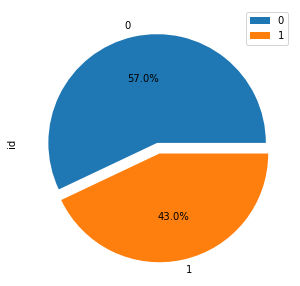

In [40]:
pie.plot.pie(y='id', figsize=(5, 5), autopct='%1.1f%%', explode=(0, 0.1))